# Solving Max Cut

This example is adapted from [this tutorial](https://docs.orquestra.io/docs/core/tutorials/basic_qaoa.html).  In this example, we will create a workflow that solves MaxCut with QAOA, using the CirqSimulator.  For more details on the content, please see the tutorial.  

In [1]:
from collections import Counter
import matplotlib.pyplot as plt

import networkx as nx
import numpy as np
from icecream import ic
import orquestra.sdk as sdk
from orquestra.integrations.cirq.simulator import CirqSimulator
from orquestra.integrations.qulacs.simulator import QulacsSimulator
from orquestra.integrations.qiskit.simulator import QiskitWavefunctionSimulator
from orquestra.quantum.runners.symbolic_simulator import SymbolicSimulator
from orquestra.opt.problems.maxcut import MaxCut
from orquestra.vqa.algorithms import QAOA

import qiskit
from qiskit import Aer
from qiskit.providers.aer.backends import StatevectorSimulator
 

@sdk.task
def create_graph():
    graph = nx.Graph()
    graph.add_nodes_from([0, 1, 2, 3, 4, 5])
    graph.add_edge(0, 1, weight=10)
    graph.add_edge(0, 3, weight=5)
    graph.add_edge(1, 2, weight=1)
    graph.add_edge(2, 3, weight=1)

    graph.add_edge(0, 4, weight=10)
    graph.add_edge(0, 5, weight=5)
    graph.add_edge(1, 4, weight=1)
    graph.add_edge(2, 4, weight=5)
    graph.add_edge(1, 5, weight=5)
    return graph

@sdk.task
def create_graph_4():
    graph = nx.Graph()
    graph.add_nodes_from([0, 1, 2, 3])
    graph.add_edge(0, 1, weight=10)
    graph.add_edge(0, 3, weight=5)
    graph.add_edge(1, 2, weight=2)
    graph.add_edge(2, 3, weight=3)
    graph.add_edge(0, 2, weight=6)
    return graph

@sdk.task
def create_graph_5():
    graph = nx.Graph()
    graph.add_nodes_from([0, 1, 2, 3, 4])
    graph.add_edge(0, 1, weight=7)
    graph.add_edge(0, 3, weight=5)
    graph.add_edge(1, 2, weight=3)
    graph.add_edge(0, 2, weight=10)
    graph.add_edge(0, 4, weight=4)
    graph.add_edge(3, 4, weight=2)
    return graph

@sdk.task
def solve_maxcut_qaoa(test_graph, runner):

    hamiltonian = MaxCut().get_hamiltonian(test_graph)
    qaoa = QAOA.default(cost_hamiltonian=hamiltonian, n_layers=2)

    #runner = runner
    opt_results = qaoa.find_optimal_params(runner=runner)

    circuit = qaoa.get_circuit(opt_results.opt_params)
    measurements = runner.run_and_measure(circuit, n_samples=10000)
    counter = Counter(measurements.bitstrings)
    most_common_string = counter.most_common()[0][0]
    return most_common_string, opt_results

@sdk.workflow
def run_max_cut(runner, graph):
    G = graph
    most_common_string, opt_results = solve_maxcut_qaoa(G, runner)
    return (G, most_common_string, opt_results)


Now we have defined a workflow.  Currently, this remains a simple example, but we are setting the stage to leverage workflows to attempt this QAOA run in many different configurations.  In fact, because this is a probabilistic process, it wont always return the same answer, so even running the exact same task N times, and looking at the range of answers can be interesting.

We will now run the workflow

In [2]:

# run workflow in local ray instance and wait for it
workflow_run = run_max_cut(CirqSimulator(), create_graph()).run("in_process")
workflow_run.wait_until_finished()


<State.SUCCEEDED: 'SUCCEEDED'>

and finally plot the results.  We will do some fancy networkx plotting where we will color the nodes of the graph according to the two groups selected by QAOA, and label the edges with the weights defined above. 

ic| opt_results: {'history': [],
                  'nfev': 108,
                  'nit': 34,
                  'opt_params': array([ 3.75667873, -0.83573618,  3.67684329,  2.02383482]),
                  'opt_value': -28.91244842984606}
ic| most_common_string: (0, 1, 0, 0, 1, 0)


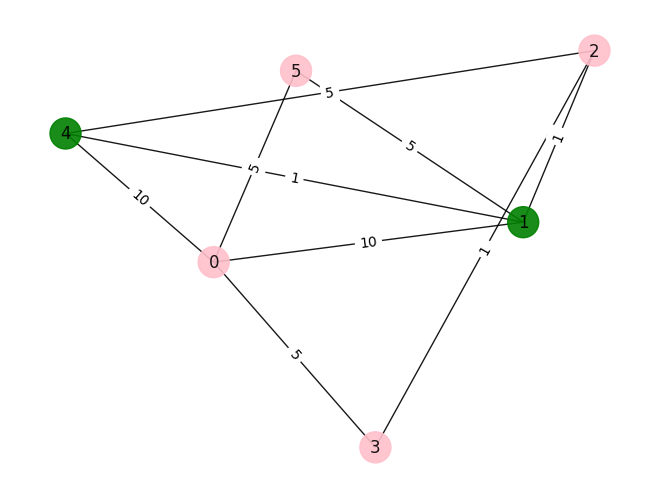

In [3]:
# grab results
G, most_common_string, opt_results = workflow_run.get_results()

# print results with ic aka. icecream
ic(opt_results)
ic(most_common_string)

# 
color_map = [['pink','green'][i] for i in most_common_string]

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color=color_map, alpha=0.9,
    labels={node: node for node in G.nodes()}
)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.axis('off')
plt.show()


### 4 nodes

ic| opt_results: {'history': [],
                  'nfev': 54,
                  'nit': 19,
                  'opt_params': array([ 2.87544774,  2.18108917, -0.50153633,  6.63159076]),
                  'opt_value': -17.61742284201742}
ic| most_common_string: (0, 1, 1, 0)


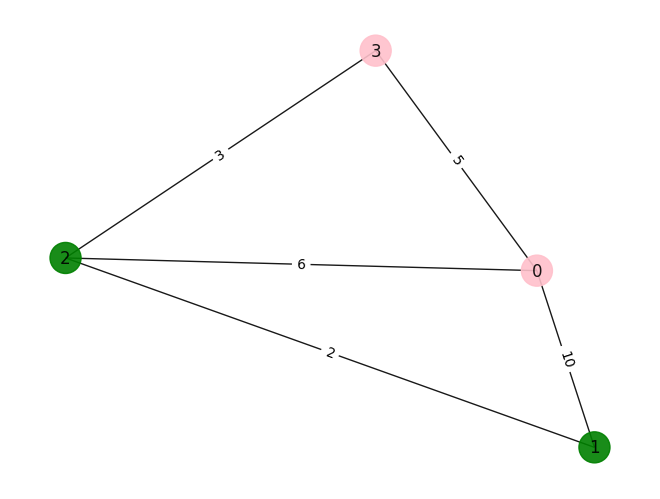

In [4]:
# run workflow in local ray instance and wait for it
workflow_run = run_max_cut(CirqSimulator(), create_graph_4()).run("in_process")
workflow_run.wait_until_finished()

# grab results
G, most_common_string, opt_results = workflow_run.get_results()

# print results with ic aka. icecream
ic(opt_results)
ic(most_common_string)

# 
color_map = [['pink','green'][i] for i in most_common_string]

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color=color_map, alpha=0.9,
    labels={node: node for node in G.nodes()}
)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.axis('off')
plt.show()

ic| opt_results: {'history': [],
                  'nfev': 23,
                  'nit': 18,
                  'opt_params': array([0.41936014, 0.8469609 , 0.57499985, 1.20677124]),
                  'opt_value': -18.943104502195254}
ic| most_common_string: (1, 0, 1, 0)


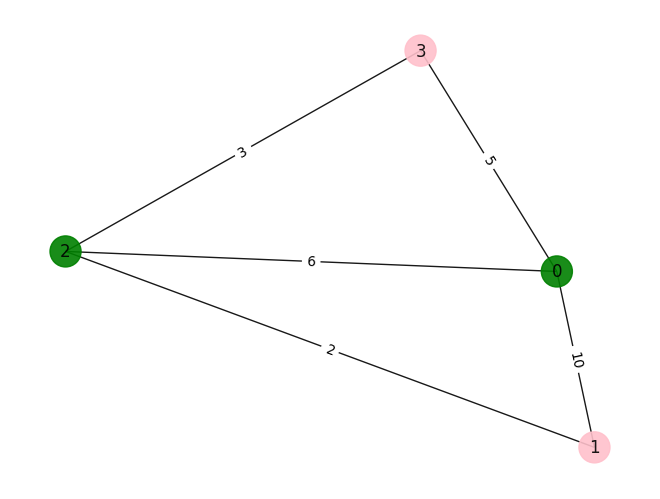

In [5]:
# run workflow in local ray instance and wait for it
workflow_run = run_max_cut(QulacsSimulator(), create_graph_4()).run("in_process")
workflow_run.wait_until_finished()

# grab results
G, most_common_string, opt_results = workflow_run.get_results()

# print results with ic aka. icecream
ic(opt_results)
ic(most_common_string)

# 
color_map = [['pink','green'][i] for i in most_common_string]

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color=color_map, alpha=0.9,
    labels={node: node for node in G.nodes()}
)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.axis('off')
plt.show()

ic| opt_results: {'history': [],
                  'nfev': 35,
                  'nit': 24,
                  'opt_params': array([2.98471319, 2.867798  , 0.39603747, 0.91909841]),
                  'opt_value': -16.887709096421688}
ic| most_common_string: (0, 1, 0, 1)


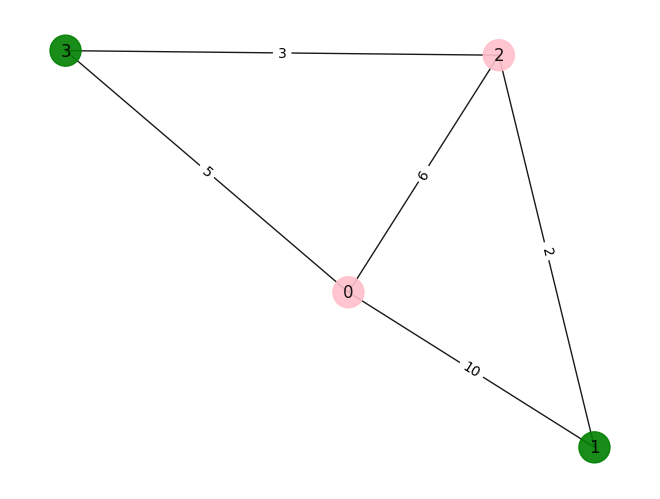

In [6]:
# run workflow in local ray instance and wait for it
workflow_run = run_max_cut(SymbolicSimulator(), create_graph_4()).run("in_process")
workflow_run.wait_until_finished()

# grab results
G, most_common_string, opt_results = workflow_run.get_results()

# print results with ic aka. icecream
ic(opt_results)
ic(most_common_string)

# 
color_map = [['pink','green'][i] for i in most_common_string]

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color=color_map, alpha=0.9,
    labels={node: node for node in G.nodes()}
)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.axis('off')
plt.show()

ic| opt_results: {'history': [],
                  'nfev': 23,
                  'nit': 16,
                  'opt_params': array([1.6631881 , 0.90355998, 2.99439914, 2.0179673 ]),
                  'opt_value': -19.380490607373908}
ic| most_common_string: (0, 1, 1, 1)


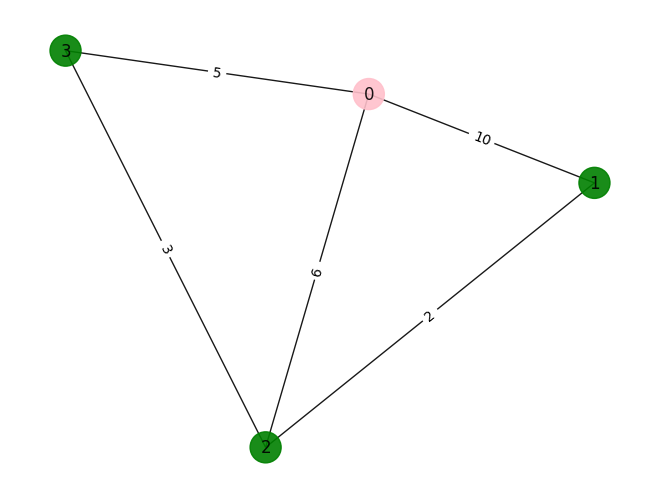

In [7]:
# run workflow in local ray instance and wait for it
workflow_run = run_max_cut(QiskitWavefunctionSimulator(StatevectorSimulator()), create_graph_4()).run("in_process")
workflow_run.wait_until_finished()

# grab results
G, most_common_string, opt_results = workflow_run.get_results()

# print results with ic aka. icecream
ic(opt_results)
ic(most_common_string)

# 
color_map = [['pink','green'][i] for i in most_common_string]

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color=color_map, alpha=0.9,
    labels={node: node for node in G.nodes()}
)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.axis('off')
plt.show()

### 5 nodes

ic| opt_results: {'history': [],
                  'nfev': 54,
                  'nit': 23,
                  'opt_params': array([ 1.10689105,  2.83181878,  2.85423588, -0.22679674]),
                  'opt_value': -19.272031153985388}
ic| most_common_string: (1, 1, 0, 0, 0)


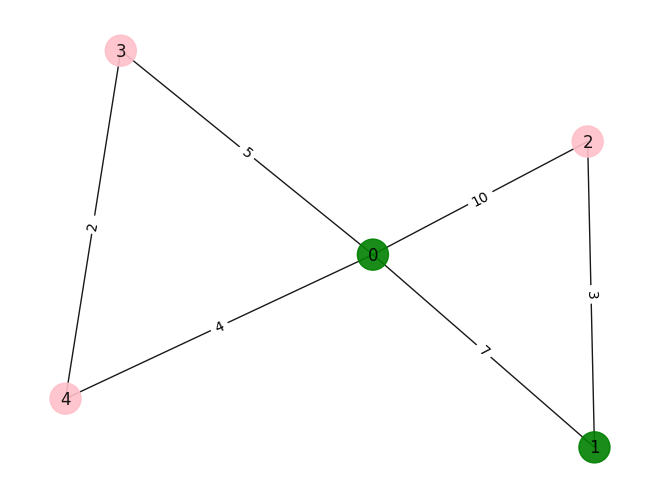

In [8]:
# run workflow in local ray instance and wait for it
workflow_run = run_max_cut(CirqSimulator(), create_graph_5()).run("in_process")
workflow_run.wait_until_finished()

# grab results
G, most_common_string, opt_results = workflow_run.get_results()

# print results with ic aka. icecream
ic(opt_results)
ic(most_common_string)

# 
color_map = [['pink','green'][i] for i in most_common_string]

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color=color_map, alpha=0.9,
    labels={node: node for node in G.nodes()}
)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.axis('off')
plt.show()

ic| opt_results: {'history': [],
                  'nfev': 33,
                  'nit': 21,
                  'opt_params': array([1.06260166, 1.44282177, 0.75458289, 0.43177959]),
                  'opt_value': -19.191185095121934}
ic| most_common_string: (1, 1, 0, 0, 0)


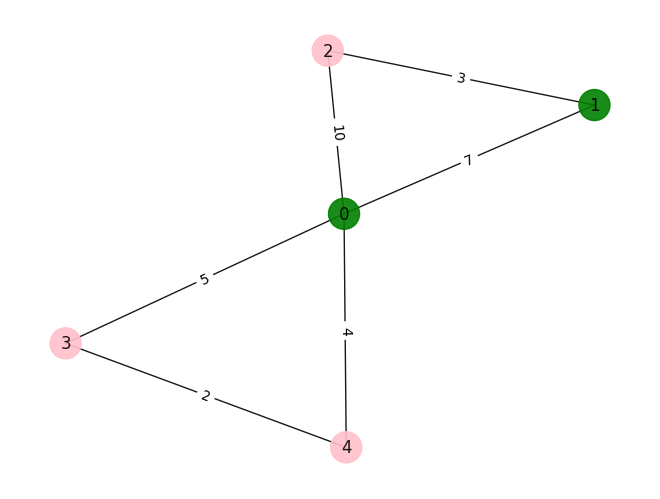

In [9]:
# run workflow in local ray instance and wait for it
workflow_run = run_max_cut(QulacsSimulator(), create_graph_5()).run("in_process")
workflow_run.wait_until_finished()

# grab results
G, most_common_string, opt_results = workflow_run.get_results()

# print results with ic aka. icecream
ic(opt_results)
ic(most_common_string)

# 
color_map = [['pink','green'][i] for i in most_common_string]

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color=color_map, alpha=0.9,
    labels={node: node for node in G.nodes()}
)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.axis('off')
plt.show()

ic| opt_results: {'history': [],
                  'nfev': 23,
                  'nit': 14,
                  'opt_params': array([ 0.53547154, -0.68834002,  2.62005331,  0.2762086 ]),
                  'opt_value': -21.21328168029434}
ic| most_common_string: (0, 1, 1, 1, 1)


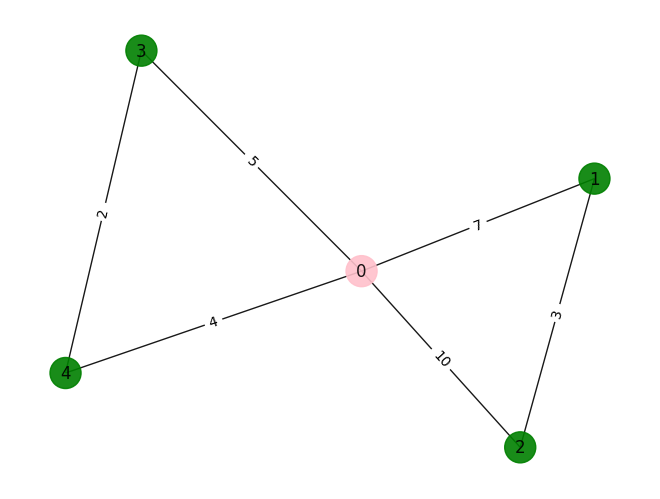

In [10]:
# run workflow in local ray instance and wait for it
workflow_run = run_max_cut(SymbolicSimulator(), create_graph_5()).run("in_process")
workflow_run.wait_until_finished()

# grab results
G, most_common_string, opt_results = workflow_run.get_results()

# print results with ic aka. icecream
ic(opt_results)
ic(most_common_string)

# 
color_map = [['pink','green'][i] for i in most_common_string]

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color=color_map, alpha=0.9,
    labels={node: node for node in G.nodes()}
)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.axis('off')
plt.show()

ic| opt_results: {'history': [],
                  'nfev': 39,
                  'nit': 27,
                  'opt_params': array([-0.67792436,  4.31112022, -2.86308933,  2.16382136]),
                  'opt_value': -22.211685121739663}
ic| most_common_string: (1, 0, 0, 1, 0)


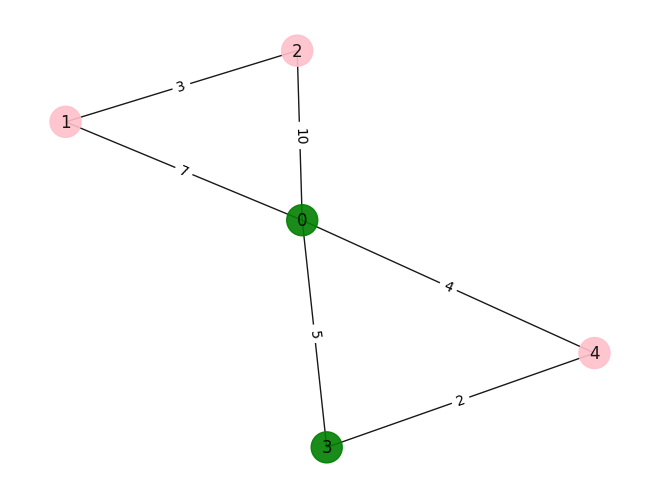

In [11]:
# run workflow in local ray instance and wait for it
workflow_run = run_max_cut(QiskitWavefunctionSimulator(StatevectorSimulator()), create_graph_5()).run("in_process")
workflow_run.wait_until_finished()

# grab results
G, most_common_string, opt_results = workflow_run.get_results()

# print results with ic aka. icecream
ic(opt_results)
ic(most_common_string)

# 
color_map = [['pink','green'][i] for i in most_common_string]

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color=color_map, alpha=0.9,
    labels={node: node for node in G.nodes()}
)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.axis('off')
plt.show()

### 6 nodes

ic| opt_results: {'history': [],
                  'nfev': 55,
                  'nit': 27,
                  'opt_params': array([2.97092747, 0.63120408, 1.65807544, 0.38011928]),
                  'opt_value': -26.065119678886667}
ic| most_common_string: (1, 1, 1, 0, 0, 0)


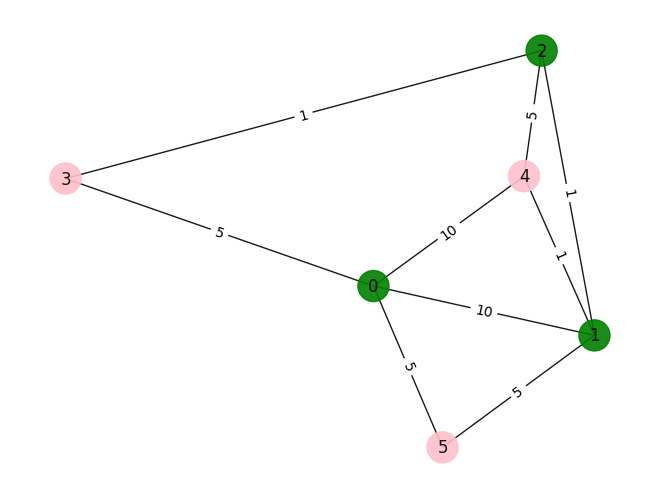

In [12]:
# run workflow in local ray instance and wait for it
workflow_run = run_max_cut(CirqSimulator(), create_graph()).run("in_process")
workflow_run.wait_until_finished()

# grab results
G, most_common_string, opt_results = workflow_run.get_results()

# print results with ic aka. icecream
ic(opt_results)
ic(most_common_string)

# 
color_map = [['pink','green'][i] for i in most_common_string]

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color=color_map, alpha=0.9,
    labels={node: node for node in G.nodes()}
)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.axis('off')
plt.show()

ic| opt_results: {'history': [],
                  'nfev': 50,
                  'nit': 34,
                  'opt_params': array([1.19151036, 0.32731163, 3.10733796, 1.82198423]),
                  'opt_value': -27.847299098685642}
ic| most_common_string: (1, 0, 0, 0, 0, 1)


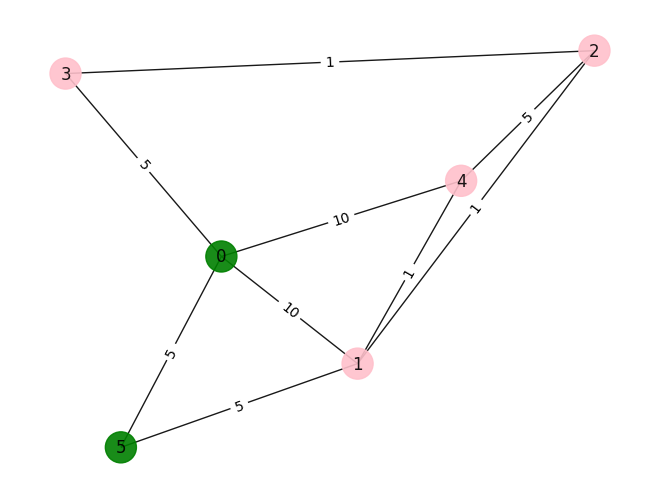

In [13]:
# run workflow in local ray instance and wait for it
workflow_run = run_max_cut(QulacsSimulator(), create_graph()).run("in_process")
workflow_run.wait_until_finished()

# grab results
G, most_common_string, opt_results = workflow_run.get_results()

# print results with ic aka. icecream
ic(opt_results)
ic(most_common_string)

# 
color_map = [['pink','green'][i] for i in most_common_string]

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color=color_map, alpha=0.9,
    labels={node: node for node in G.nodes()}
)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.axis('off')
plt.show()

ic| opt_results: {'history': [],
                  'nfev': 22,
                  'nit': 17,
                  'opt_params': array([1.96333327, 1.10621214, 2.0969766 , 1.63094303]),
                  'opt_value': -26.60820395561615}
ic| most_common_string: (0, 1, 0, 0, 1, 1)


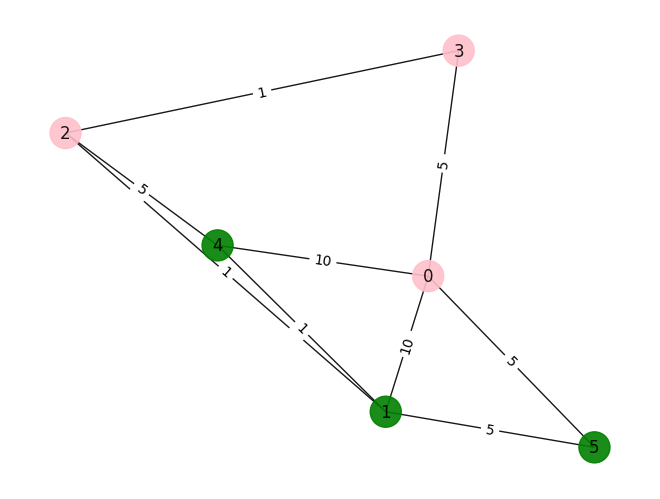

In [14]:
# run workflow in local ray instance and wait for it
workflow_run = run_max_cut(SymbolicSimulator(), create_graph()).run("in_process")
workflow_run.wait_until_finished()

# grab results
G, most_common_string, opt_results = workflow_run.get_results()

# print results with ic aka. icecream
ic(opt_results)
ic(most_common_string)

# 
color_map = [['pink','green'][i] for i in most_common_string]

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color=color_map, alpha=0.9,
    labels={node: node for node in G.nodes()}
)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.axis('off')
plt.show()

ic| opt_results: {'history': [],
                  'nfev': 26,
                  'nit': 20,
                  'opt_params': array([1.16344762, 2.02351355, 2.55417795, 1.61935463]),
                  'opt_value': -27.136671549101337}
ic| most_common_string: (0, 1, 1, 1, 1, 0)


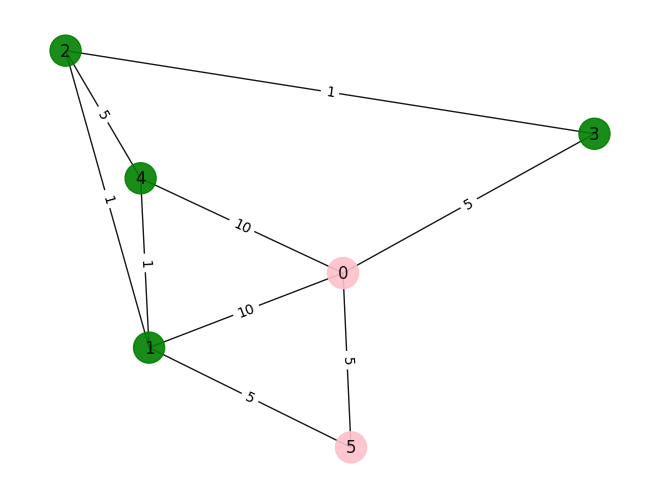

In [15]:
workflow_run = run_max_cut(QiskitWavefunctionSimulator(StatevectorSimulator()), create_graph()).run("in_process")
workflow_run.wait_until_finished()

# grab results
G, most_common_string, opt_results = workflow_run.get_results()

# print results with ic aka. icecream
ic(opt_results)
ic(most_common_string)

# 
color_map = [['pink','green'][i] for i in most_common_string]

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color=color_map, alpha=0.9,
    labels={node: node for node in G.nodes()}
)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

plt.axis('off')
plt.show()